# Detecting Emotions Using ResNets

<img src="img/emotions.jpg" style="width:600px;height:300px"/>

### importing the required packages

In [78]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from seaborn import *


import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import figure

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import layers


In [59]:
train_dir = "train/"
test_dir = "test/"

In [60]:
# since the images are 48 * 48 pixels so we can use 48 as side length
side = 48
# the classes in the dataset
classes = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
# in this dataset we have 7 classes which are [angry, disgusted, fearful, happy, sad, surprised, neutral]
no_classes = 7

[3995, 436, 4097, 7215, 4965, 4830, 3171]


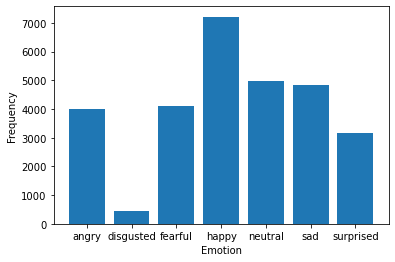

[958, 111, 1024, 1774, 1233, 1247, 831]


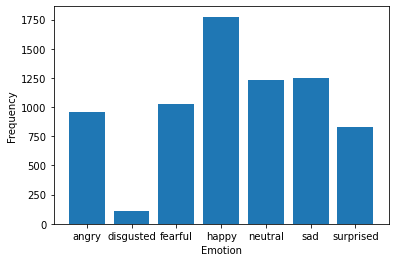

In [61]:
def emotion_dist(path):
    frequencies = {}
    emotions = []
    freq = []
    for emotion in os.listdir(path):
        emotions.append(emotion)
        freq.append(len(os.listdir(path + emotion)))
        #frequencies[emotion] = len(os.listdir(path + expression))
    plt.bar(emotions,freq, align='center')
    print(freq)
    plt.xlabel('Emotion')
    plt.ylabel('Frequency')
    plt.show()
    
emotion_dist(train_dir)
emotion_dist(test_dir)
    
        

### visualize some images

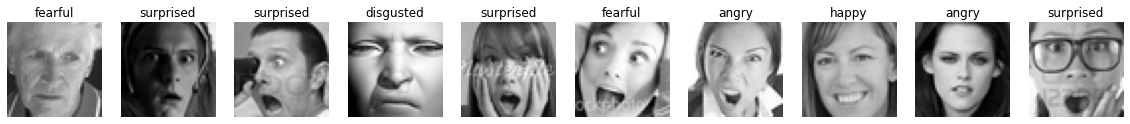

In [62]:
#visualizing random images from the training set
figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    rand_class = np.random.randint(0, 6)
    # 110 here is because the folder with the least no. of images has 110 images
    rand_im = np.random.randint(0, 110)
    fname = "/im" + str(rand_im) + ".png"
    image = Image.open(train_dir + classes[rand_class] + fname).convert("L")
    arr = np.asarray(image)
    plt.title(classes[rand_class])
    plt.axis('off')
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)


### perform image augmentation

In [63]:
# implementing on the fly data augmentation using ImageDataGetnerator
train_generator = ImageDataGenerator(rotation_range= 30,
                              rescale= 1.0/255,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              width_shift_range=0.2,
                              height_shift_range=0.2)

training_data = train_generator.flow_from_directory(train_dir,
                                             target_size=(side,side),
                                             batch_size=16,
                                             color_mode = "grayscale",
                                             class_mode = "categorical")

Found 28709 images belonging to 7 classes.


In [64]:
# implementing on the fly data augmentation using ImageDataGetnerator for validation and testing
test_generator = ImageDataGenerator(rescale= 1.0/255)

validation_data = test_generator.flow_from_directory(train_dir,
                                             target_size=(side,side),
                                             batch_size=16,
                                             color_mode = "grayscale",
                                             class_mode = "categorical")

test_data = test_generator.flow_from_directory(test_dir,
                                             target_size=(side,side),
                                             batch_size=16,
                                             color_mode = "grayscale",
                                             class_mode = "categorical")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## The model

The Model that will be implemented is a ResNet model. The model will consist of multiple identity blocks and convolutional blocks which use the idea of skip connections to handle deep networks gradients. The two blocks mentioned differ in that the identity block input has the same shape as the output of the middle convolutions so we can add them directly, while in the case of convolutional block we do a conv on the input to match the output as described in the figures above each block.

Note: Model components are reused from an assignment that I had recently solved.

### Identity block

The structure of the identity block

<img src="img/identity.png" style="width:1000px;height:350px"/>

In [65]:

def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    X --> Input tensor
    f --> The kernel size of the middle conolution
    filters --> The number of filters that will be used in each of the three CONV layers
    training --> 1 for training, 0 for inference
    initializer --> How to set the initial weights of the network
    
    X as output is the output of this identity block
    """
    
    # Getting the number of filters that will be used in each conv
    F1, F2, F3 = filters
    
    # Saving the values of the inputs in order to use it in the skip connection
    X_shortcut = X
    
    # The convolutions of this block
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X) 

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    # Add the values that we saved to the ones that we have
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = Activation('relu')(X) 

    return X

### Convolutional block

The structure of the convolutional block

<img src="img/convB.png" style="width:1000px;height:350px"/>

In [66]:

def convolutional_block(X, f, filters, s = 2, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    X --> Input tensor
    f --> The kernel size of the middle conolution
    filters --> The number of filters that will be used in each of the three CONV layers
    s --> specifiying the stride
    training --> 1 for training, 0 for inference
    initializer --> How to set the initial weights of the network
    
    X as output is the output of this identity block
    """
    
    # Getting the number of filters that will be used in each conv
    F1, F2, F3 = filters
    
    # Saving the values of the inputs in order to use it in the skip connection
    X_shortcut = X

    # The convolutions of this block
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training) 
    X = Activation('relu')(X) 

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training) 
    
    # The convolution on the input to be added as a skip connection
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training) 

    # Add the values that we saved to the ones that we have
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## ResNet architecture

<img src="The-structure-of-ResNet-12.png" style="width:200px;height:200px"/>

<h6><center>A figure of ResNet-12 which is similar to the one used</center></h6>

### Why 22?

The reduction from the conventional ResNet50 to Resnet22 is just for the sole purpose of making training on my local machine faster. In this project accuracy is not a priority but rather applying concepts.

### The flow

Since this is a variation of ResNets, it uses skip connections which happen in convolutional blocks and identity blocks (These two kinds of blocks were explained earlier). 

In [67]:

def ResNet22(input_shape, classes):
    """
    input_shape --> shape of the images of the dataset
    classes --> number of classes

    model as output is a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2) 
    X = identity_block(X, 3, [128, 128, 512]) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512]) 

    X = AveragePooling2D(pool_size = (2, 2))(X) 
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
        model = Model(inputs = X_input, outputs = X)

    return model

In [68]:
model = ResNet22(input_shape = (side, side, 1), classes = no_classes)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 54, 54, 1)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_91 (Conv2D)             (None, 24, 24, 64)   3200        ['zero_padding2d_3[0][0]']       
                                                                                                  
 batch_normalization_91 (BatchN  (None, 24, 24, 64)  256         ['conv2d_91[0][0]']        

In [69]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
history = model.fit(training_data, epochs=30, validation_data = validation_data)

Epoch 1/30
1795/1795 [==============================] - 72s 38ms/step - loss: 2.0283 - accuracy: 0.2503 - val_loss: 1.6624 - val_accuracy: 0.3472
Epoch 2/30
1795/1795 [==============================] - 71s 40ms/step - loss: 1.6940 - accuracy: 0.3214 - val_loss: 1.5300 - val_accuracy: 0.4123
Epoch 3/30
1795/1795 [==============================] - 71s 40ms/step - loss: 1.5679 - accuracy: 0.3879 - val_loss: 1.4249 - val_accuracy: 0.4560
Epoch 4/30
1795/1795 [==============================] - 68s 38ms/step - loss: 1.4603 - accuracy: 0.4340 - val_loss: 1.3530 - val_accuracy: 0.4884
Epoch 5/30
1795/1795 [==============================] - 71s 40ms/step - loss: 1.3910 - accuracy: 0.4641 - val_loss: 1.2591 - val_accuracy: 0.5195
Epoch 6/30
1795/1795 [==============================] - 71s 39ms/step - loss: 1.3481 - accuracy: 0.4840 - val_loss: 1.1991 - val_accuracy: 0.5448
Epoch 7/30
1795/1795 [==============================] - 69s 39ms/step - loss: 1.3052 - accuracy: 0.5047 - val_loss: 1.1986 -

## Model evaluation

### Accuracy plot

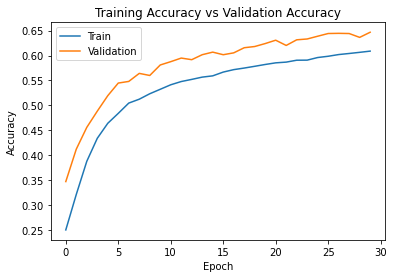

In [95]:
fig.set_size_inches(10,5)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Evaluating over testing data

In [75]:
model.evaluate(test_data)
preds = model.predict(test_data)

449/449 [==============================] - 8s 17ms/step - loss: 1.0241 - accuracy: 0.6108


The reults show that the model is not overfitting the training data. It might also gain higher accuracy with further training.